# Laser Shooting

**Problem**
- We can calculate position of target relative to camera.
- How should we move laser from our target position.

In [1]:
%matplotlib widget
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def circle_intersec(x0, y0, r0, x1, y1, r1):
    # circle 1: (x0, y0), radius r0
    # circle 2: (x1, y1), radius r1

    d = math.sqrt((x1 - x0) ** 2 + (y1 - y0) ** 2)

    # non intersecting
    if d > r0 + r1:
        return None
    # One circle within other
    if d < abs(r0 - r1):
        return None
    # coincident circles
    if d == 0 and r0 == r1:
        return None
    else:
        a = (r0**2 - r1**2 + d**2) / (2 * d)
        h = math.sqrt(r0**2 - a**2)
        x2 = x0 + a * (x1 - x0) / d
        y2 = y0 + a * (y1 - y0) / d
        x3 = x2 + h * (y1 - y0) / d
        y3 = y2 - h * (x1 - x0) / d

        x4 = x2 - h * (y1 - y0) / d
        y4 = y2 + h * (x1 - x0) / d

        return (x3, y3, x4, y4)

In [3]:
def distance(x0, y0, x1, y1):
    return math.sqrt(pow(x1 - x0, 2) + pow(y1 - y0, 2))

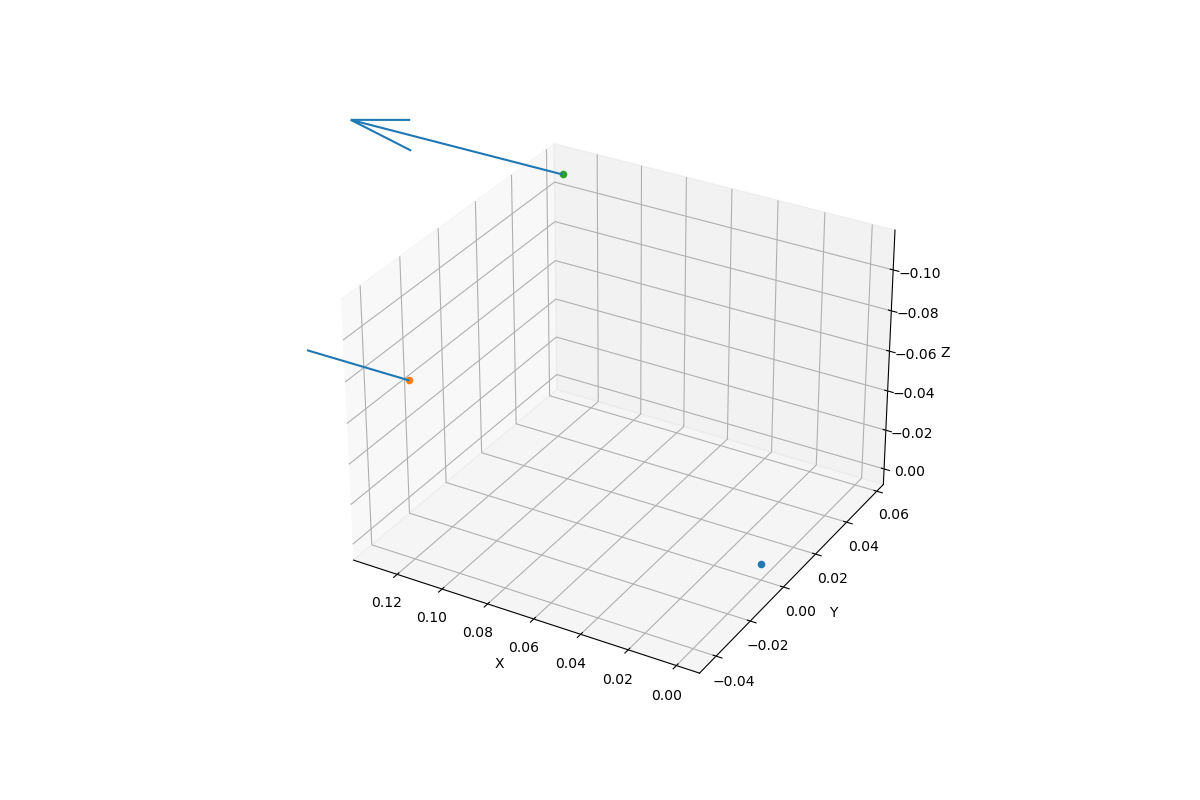

In [4]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection="3d")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.invert_zaxis()
ax.invert_xaxis()
ax.invert_yaxis()

# center point
ax.scatter3D(0, 0, 0)

# Nav cam
# ax.plot([0, 0.1177], [0, -0.0422], [0, -0.0826])
ax.scatter3D(0.1177, -0.0422, -0.0826)
ax.quiver(0.1177, -0.0422, -0.0826, 1, 0, 0, length=0.1)

# laser
ax.scatter3D(0.1302, 0.0572, -0.1111)
ax.quiver(0.1302, 0.0572, -0.1111, 1, 0, 0, length=0.1)

# ax.scatter3D(0.5771599999999992, -0.0044005491850808015, 0.024569734389619735)

## Calculate target position

In [5]:
# CONSTANT
cam_mat = np.array(
    [
        [523.105750, 0.000000, 635.434258],
        [0.000000, 534.765913, 500.335102],
        [0.000000, 0.000000, 1.000000],
    ]
)
dist_coeffs = np.array([-0.164787, 0.020375, -0.001572, -0.000369, 0.000000])
newcam_mat, _ = cv2.getOptimalNewCameraMatrix(
    cam_mat, dist_coeffs, (1280, 960), 1, (1280, 960)
)
# cam_mat
# np.linalg.inv(newcam_mat)

#### 1. Find target position on image 

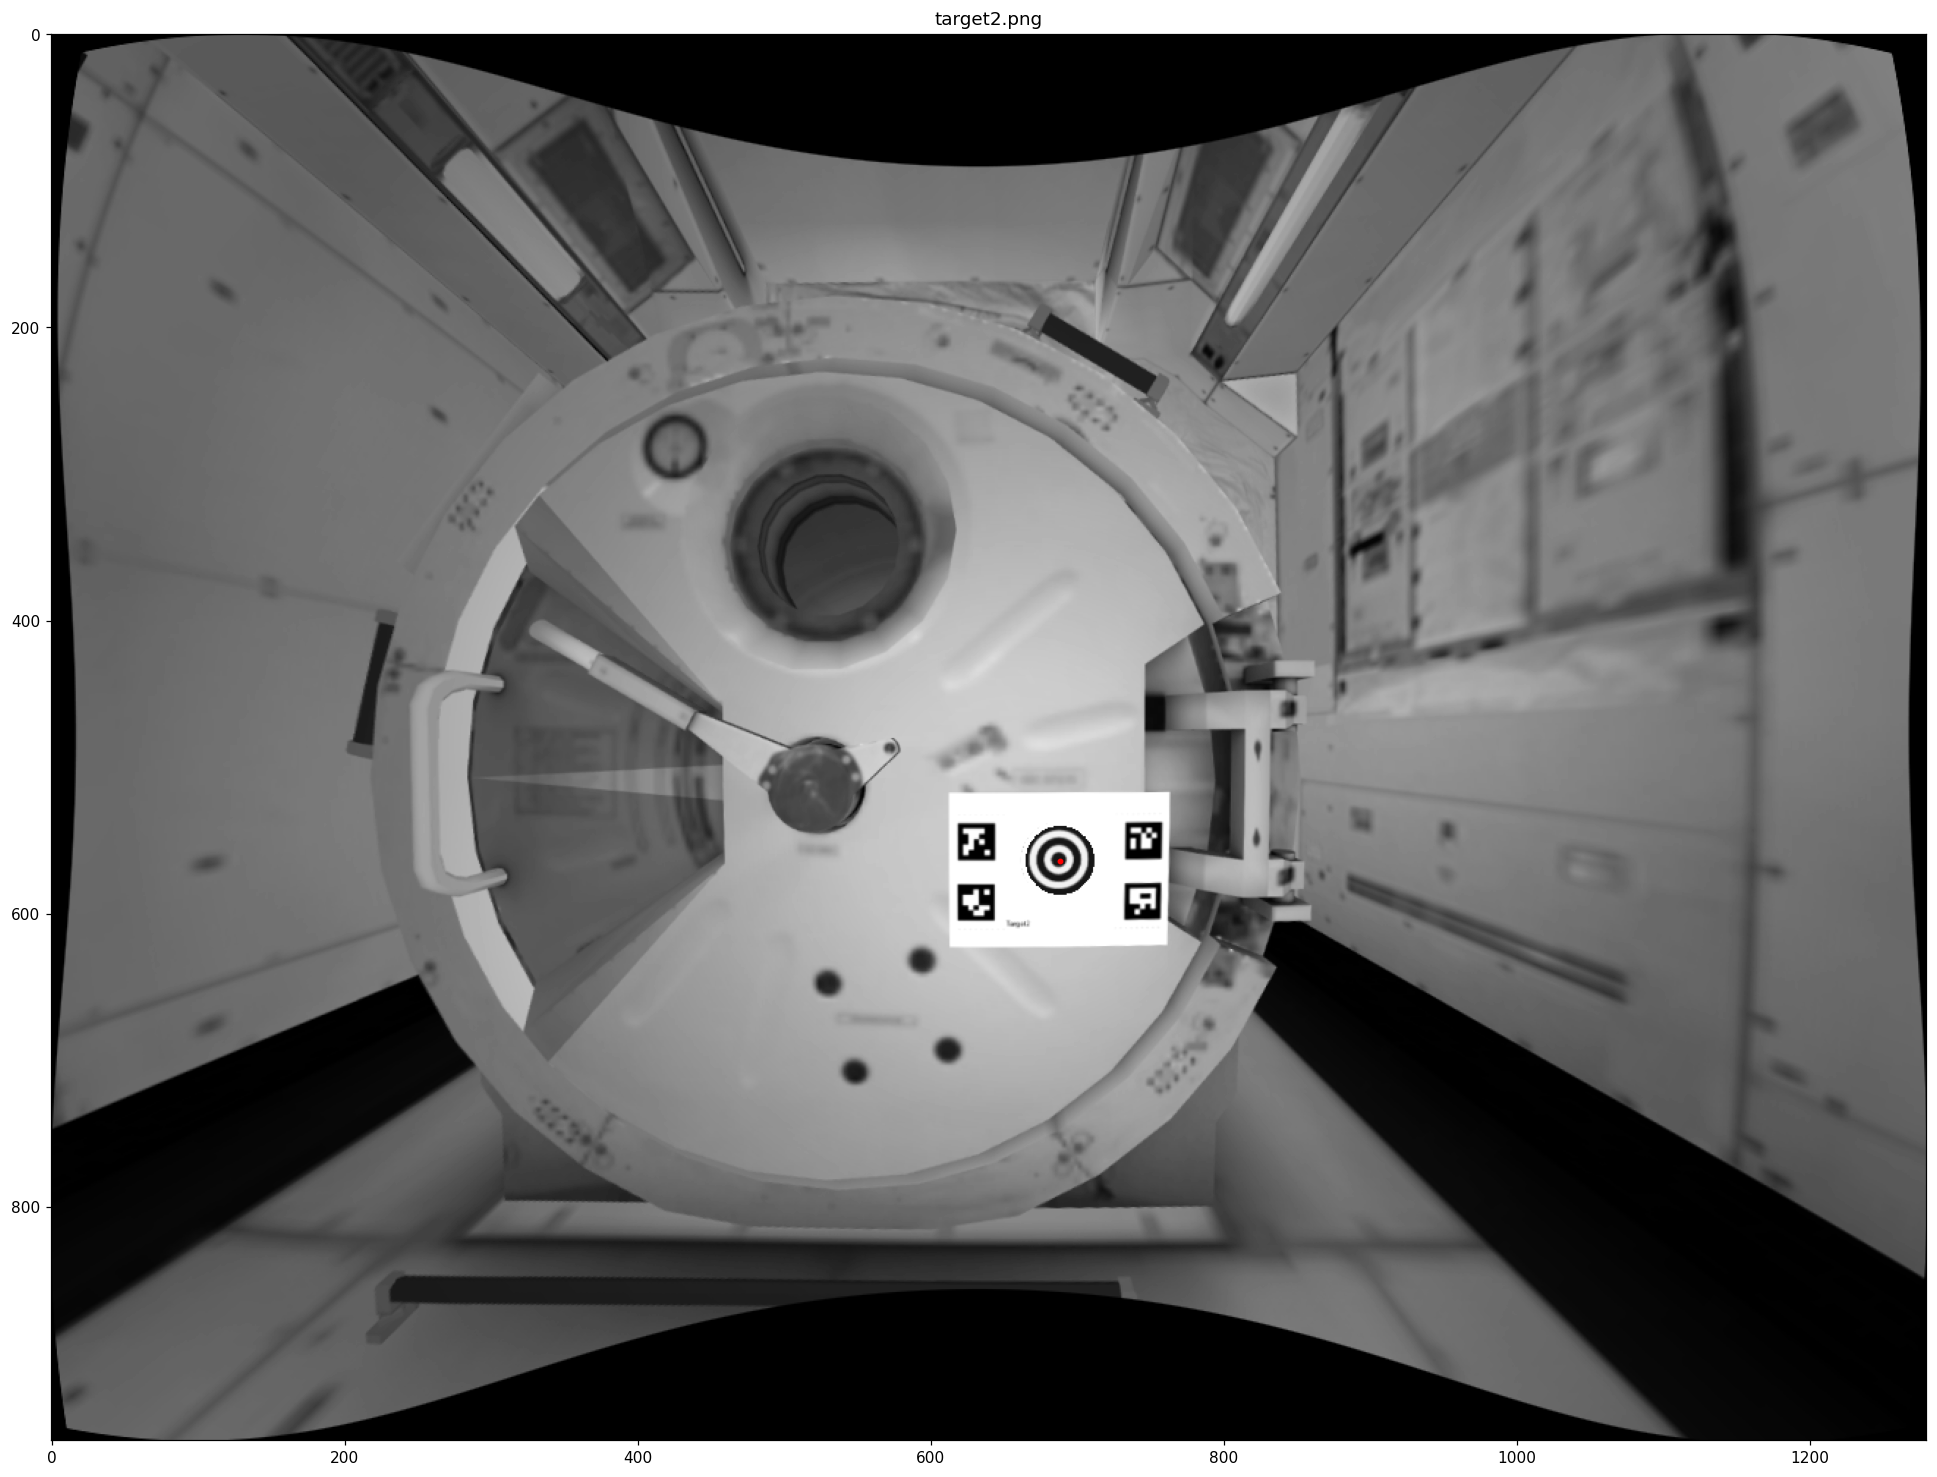

In [6]:
%matplotlib inline
fig = plt.figure(figsize=(22, 22), dpi=110)
img = cv2.imread("../Img/target2.png", cv2.IMREAD_GRAYSCALE)
out = cv2.undistort(img, cam_mat, dist_coeffs, None, newcam_mat)
circles = cv2.HoughCircles(
    out, cv2.HOUGH_GRADIENT, 1, 1300, param1=50, param2=30, minRadius=10, maxRadius=40
)
circles = np.uint16(np.around(circles))
center = circles[0][0]

ax = fig.add_subplot()
ax.set_title("target2.png")

for i in circles[0, :]:
    # drawing
    cv2.circle(out, (i[0], i[1]), i[2], (255, 0, 0), 2)
    ax.scatter(i[0], i[1], c="red", s=8)

ax.imshow(out, cmap="gray")

#### 2. Calculate world position

In [7]:
# center = np.array([688.380859375, 562.182373046875])
center

array([688, 564,  25], dtype=uint16)

#### Use pinhole camera model to compute position in camera cordinate
From [OpenCv Doc](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#)

Distance from point 2 to target is 

$s = |Z_t - (-Z_{p2}-Z_{nav})|$ \
$s = \text{Distance to target} = 0.45946$ \
$A = \text{Camera Matrix}$

$$\begin{bmatrix}
X_c \\ Y_c \\ Z_c
\end{bmatrix}
=A^{-1}s\begin{bmatrix}
u \\ v \\ 1
\end{bmatrix}$$

In [8]:
s = abs(-10.5 - (-9.92284 - 0.1177))
uv = np.array([[center[0]], [center[1]], [1]])
uv = np.dot(s, uv)
A_inv = np.linalg.inv(newcam_mat)
cam_c = np.matmul(A_inv, uv)
s, cam_c

(0.45946,
 array([[0.07215658],
        [0.08915872],
        [0.45946   ]]))

In [9]:
# camera cordinate with offset to world
cam_c[0][0] - 0.0422, cam_c[1][0] - 0.0826, s

(0.029956581270919283, 0.006558719025522963, 0.45946)

#### Use meter/pixel approximation
AR tag in realworld is 0.05 m width and height so we use this information to calculate $C$ (meter/pixel constant) \
$C$ (meter/pixel) $= \frac{0.05}{\text{s_len}}$

In [10]:
# reading ar tag
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_250)
corners, ids, _ = cv2.aruco.detectMarkers(out, aruco_dict)

In [11]:
s_len = 0
for i in range(len(corners)):
    c = corners[i][0]
    s1 = distance(c[0][0], c[0][1], c[1][0], c[1][1])
    s2 = distance(c[1][0], c[1][1], c[2][0], c[2][1])
    s3 = distance(c[2][0], c[2][1], c[3][0], c[3][1])
    s4 = distance(c[3][0], c[3][1], c[0][0], c[0][1])
    s_avg = sum([s1, s2, s3, s4]) / 4
    s_len += s_avg

s_len /= 4
s_len

24.321506594214398

In [12]:
meter_px = 0.05 / s_len
meter_px

0.002055793698729749

Calculating world cordinate by using difference from camera center

In [13]:
cx, cy = 635.434258, 500.335102  # this is from camera matrix
xdist = center[0] - cx
ydist = center[1] - cy
xdist, ydist

(52.565742, 63.664897999999994)

In [14]:
# convert to meter
xdist *= meter_px
ydist *= meter_px
# target distance
target_dist = abs(-10.5 - (-9.92284))
target_dist

xdist, ydist, target_dist

(0.10806432117265373, 0.1308818961386722, 0.5771599999999992)

## Calculating angle to turn

### Circle method 
Based on https://youtu.be/_eJM4LArG18 \
Simple visualization https://www.desmos.com/calculator/xx9zlhkxfs

##### YZ Plane

Compute $\text{r1}$, $\text{r2}$, $l$

In [38]:
# target distance
t_l = abs(-10.5 - (-9.92284))

In [39]:
pivot_angle = math.radians(math.degrees(math.atan(0.1302 / 0.1111)) + 90)
pivot_angle, math.degrees(pivot_angle)

(2.4351843752901243, 139.5257870403261)

In [40]:
r1 = math.sqrt(0.1302**2 + 0.1111**2)
l = math.sqrt(t_l**2 + -((cam_c[1][0] - 0.0826) ** 2))
r2 = r1 * math.cos(pivot_angle) + math.sqrt(
    l**2 - (r1**2) * pow(math.sin(pivot_angle), 2)
)
l, r1, r2

(0.577122732878149, 0.1711585522257068, 0.43612803109570975)

In [41]:
intersec = circle_intersec(
    0,
    0,
    r1,
    t_l,
    -(cam_c[1][0] - 0.0826),
    r2,
)
intersec

(0.1482449273788534,
 -0.0855493512917456,
 0.15015072185504094,
 0.0821584489046023)

Compute angle using biggest x on intersection points

In [42]:
# triangle base
tri_base = distance(0.1302, 0.1111, intersec[2], intersec[3])
angle = 2 * math.atan((tri_base / 2) / r1)
f"∠x : {angle}, {math.degrees(angle)}°"

'∠x : 0.20465794977319016, 11.72603676580418°'

##### XY Plane

Compute $\text{r1}$, $\text{r2}$, $l$

In [43]:
t_l = abs(-10.5 - (-9.92284))

In [44]:
pivot_angle = math.radians(math.degrees(math.atan(0.0572 / 0.1302)) + 90)
pivot_angle, math.degrees(pivot_angle)

(1.984736804241342, 113.71704232731156)

In [45]:
r1 = math.sqrt(0.1302**2 + 0.0572**2)
# cam_c[0][0] - 0.0422 is a difference between camera and pivot
l = math.sqrt(t_l**2 + (cam_c[0][0] - 0.0422) ** 2)
r2 = r1 * math.cos(pivot_angle) + math.sqrt(
    l**2 - (r1**2) * pow(math.sin(pivot_angle), 2)
)
l, r1, r2

(0.577936901712843, 0.14221068876846074, 0.5058799431354666)

In [46]:
intersec = circle_intersec(0, 0, r1, cam_c[0][0] - 0.0422, t_l, r2)
intersec

(0.11822256185256454,
 0.07903990048713726,
 -0.10940445925410615,
 0.09085452270149592)

Compute angle using biggest x on intersection points

In [47]:
tri_base = distance(0.1302, 0.0572, intersec[0], intersec[1])
angle = 2 * math.atan((tri_base / 2) / r1)
f"∠y : {angle}, {math.degrees(angle)}°"

'∠y : 0.17470733111606082, 10.009992722944887°'

### Simple Trigonometry
We need to change reference frame from camera to laser in implementation by some way

In [48]:
x_angle = math.atan(xdist / target_dist)
y_angle = math.atan(ydist / target_dist)
print(f"∠x : {x_angle} , {math.degrees(x_angle)}°")
print(f"∠y : {y_angle} , {math.degrees(y_angle)}°")

∠x : 0.18509155031749566 , 10.604964656725814°
∠y : 0.22299739815587327 , 12.776809756729946°


## Other Things

In [26]:
def rotateV(x, y, angle):
    x1 = x * math.cos(angle) - y * math.sin(angle)
    y1 = x * math.sin(angle) + y * math.cos(angle)
    return x1, y1


rotateV(0, 1, angle)

(-0.17381993132396084, 0.9847774527651075)